In [70]:
from pyciemss import PetriNetODE

In [71]:
import os

from pyciemss.PetriNetODE.base import ScaledBetaNoisePetriNetODESystem
from pyciemss.PetriNetODE.interfaces import load_petri_model, setup_model, sample, calibrate
import pyciemss
import numpy as np

Most of our files are relative to `test/models/`, so we need to go up a directory.

In [72]:
MIRA_PATH = "../test/models/evaluation_examples/scenario_1/"
filename = "scenario1_sir_mira.json"
filename = os.path.join(MIRA_PATH, filename)


model = load_petri_model(filename, add_uncertainty=True, pseudocount=10000)
model = setup_model(model, start_time=0.0, start_state=dict(susceptible_population=0.99, infected_population=0.01, immune_population=0.0))

In [73]:
model

ScaledBetaNoisePetriNetODESystem(
	beta = Uniform(low: 0.09000000357627869, high: 0.10999999940395355),
	gamma = Uniform(low: 0.18000000715255737, high: 0.2199999988079071),
	pseudocount = 10000
)

In [74]:
import matplotlib.pyplot as plt

def plot_sample(times, s, names, alpha=1, **kwargs):
    for i,name in enumerate(names):
        for trajectory in s[name]:
            plt.plot(times, trajectory, label=name, alpha=alpha, color='C' + str(i), **kwargs)

Text(0, 0.5, 'gamma')

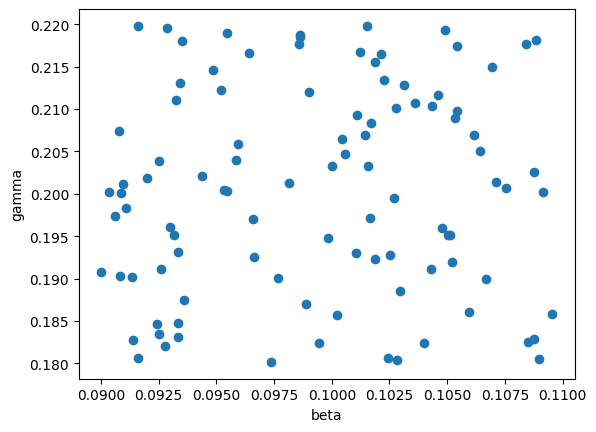

In [75]:
import random
import pyro
pyro.set_rng_seed(3)
random.seed(0)
times = np.linspace(0.01, 30, 100)
num_samples = 100
data = sample(model, times, num_samples)
plt.scatter(data["beta"], data["gamma"])
plt.xlabel("beta")
plt.ylabel("gamma")

In [76]:
observed_indices = np.sort(np.random.choice(range(0,100), 10, replace=False))
observed_indices

array([ 6, 15, 25, 42, 64, 67, 83, 93, 96, 98])

In [77]:
import pyro
mu = data['infected_population_sol'][0][observed_indices]
obs_times = times[observed_indices]
obs_vals = pyro.distributions.Beta(mu * model.pseudocount, (1 - mu) * model.pseudocount).sample()

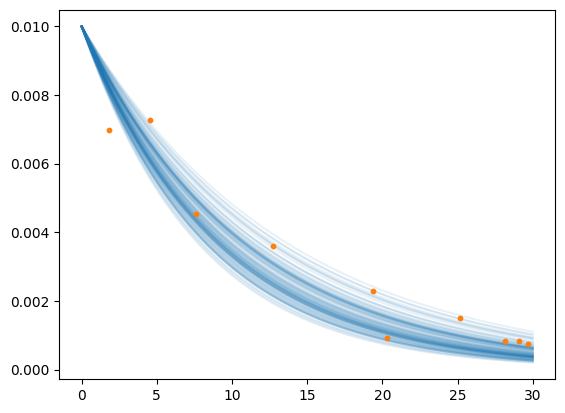

In [78]:
plot_sample(times, data, ('infected_population_sol',), alpha=0.1, zorder=1)
plt.scatter(obs_times, obs_vals, color='C1', zorder=2, s=10)

In [79]:
obs = [(times[j], 
        {"infected_population": float(data["infected_population_sol"][0,j])})
    for j in observed_indices]

In [80]:
len(obs)

10

In [81]:
post = calibrate(model, obs, verbose=True, num_iterations=300)
post

iteration 0: loss = -58.54895567893982
iteration 25: loss = -64.41927909851074
iteration 50: loss = -64.16614419221878
iteration 75: loss = -64.85448455810547
iteration 100: loss = -65.57025146484375
iteration 125: loss = -65.41922378540039
iteration 150: loss = -65.03285217285156
iteration 175: loss = -65.03262555599213
iteration 200: loss = -65.70933258533478
iteration 225: loss = -65.67618918418884
iteration 250: loss = -65.80793237686157
iteration 275: loss = -65.57891607284546


AutoLowRankMultivariateNormal()

In [82]:
post_sample = sample(model, np.linspace(0.01, 30, 100), 100, inferred_parameters=post)

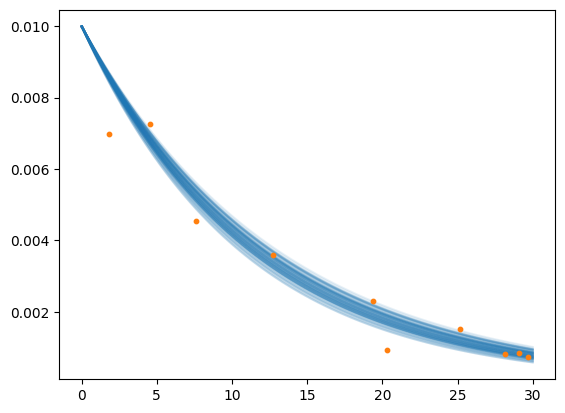

In [83]:
plot_sample(times, post_sample, ('infected_population_sol',), alpha=0.1, zorder=1)
plt.scatter(times[observed_indices], obs_vals, color='C1', zorder=2, s=10)

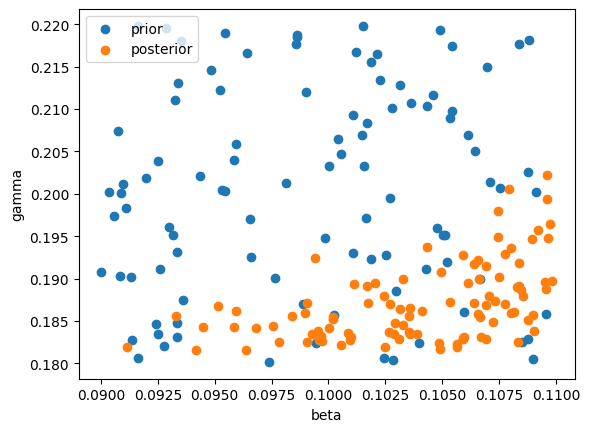

In [91]:
plt.scatter(data["beta"], data["gamma"], label="prior")
plt.scatter(post_sample["beta"], post_sample["gamma"], label="posterior")
plt.xlabel("beta")
plt.ylabel("gamma")
plt.legend(loc=2)